In [2]:
# Author: Davide Aloi - PhD student - University of Birmingham
# The script loads the electrode and / or cod liver oil masks and subtract them from the 
# T1 scan. This is done to remove electrodes / paste / cod liver oil from the t1s, as roast,
# was segmenting them as skull.
# The script also saves a txt file in each participants' folder, with the coordinates of the 
# anodal and cathodal electrodes.

In [1]:
import numpy as np
import nilearn
import os
import glob

main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 
output_folder = 'D:\\roast-chapter3\\wp_all_results\\' # where to save results
data_folder = 'D:\\roast-chapter3\\'

# Datasets names and subjects lists
db_names = ['wp2a']

# List of coordinates for each subject (return electrode: cathodal, active electrode: anodal)
cath_coords = {
            '01': (136,192,187),
            '02': (136,205,184),
            '03': (121,214,199),
            '04': (139,195,180),
            '06': (135,186,188),
            '07': (142,183,196),
            '08': (148,182,188),
            '09': (142,186,187),
            '10': (151,180,182),
            '11': (149,189,179),
            '12': (146,185,189),
            '13': (145,191,189),
            '14': (131,186,202),
            '15': (134,192,193),
            '16': (133,185,193),
            '17': (133,185,190),
            '18': (140,190,185),
            '19': (158,183,172),
            '20': (156,174,190),
            '22': (147,179,181),
            '23': (142,187,180),
            '24': (132,182,190)
}
anod_coords = {
            '01': (69,79,223),
            '02': (44,96,211),
            '03': (37,100,201),
            '04': (38,109,197),
            '06': (36,86,189),
            '07': (46,75,213),
            '08': (40,75,193),
            '09': (37,88,194),
            '10': (40,75,190),
            '11': (49,81,211),
            '12': (49,66,203),
            '13': (49,94,216),
            '14': (46,60,209),
            '15': (36,73,199),
            '16': (47,76,204),
            '17': (40,83,204),
            '18': (46,99,216),
            '19': (28,97,190),
            '20': (40,72,198),
            '22': (46,94,210),
            '23': (44,93,207),
            '24': (37,95,199)
}



C:\Users\davide\miniconda3\envs\neuroimg\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
0it [00:00, ?it/s]

D:\roast-chapter3\wp2a\sub-03


1it [00:10, 10.00s/it]

D:\roast-chapter3\wp2a\sub-04


2it [00:19,  9.83s/it]

D:\roast-chapter3\wp2a\sub-06


3it [00:29,  9.92s/it]

D:\roast-chapter3\wp2a\sub-07


4it [00:40, 10.27s/it]

D:\roast-chapter3\wp2a\sub-08


5it [00:51, 10.41s/it]

D:\roast-chapter3\wp2a\sub-09


6it [01:00, 10.13s/it]

D:\roast-chapter3\wp2a\sub-10


7it [01:10,  9.87s/it]

D:\roast-chapter3\wp2a\sub-11


8it [01:19,  9.83s/it]

D:\roast-chapter3\wp2a\sub-12


9it [01:29,  9.82s/it]

D:\roast-chapter3\wp2a\sub-13


10it [01:39,  9.68s/it]

D:\roast-chapter3\wp2a\sub-15


11it [01:48,  9.57s/it]

D:\roast-chapter3\wp2a\sub-16


12it [01:57,  9.52s/it]

D:\roast-chapter3\wp2a\sub-17


13it [02:07,  9.50s/it]

D:\roast-chapter3\wp2a\sub-18


14it [02:17,  9.70s/it]

D:\roast-chapter3\wp2a\sub-19


15it [02:27,  9.96s/it]

D:\roast-chapter3\wp2a\sub-20


16it [02:38, 10.16s/it]

D:\roast-chapter3\wp2a\sub-22


17it [02:51, 11.01s/it]

D:\roast-chapter3\wp2a\sub-23


18it [03:01, 10.83s/it]

D:\roast-chapter3\wp2a\sub-24


19it [03:12, 10.12s/it]


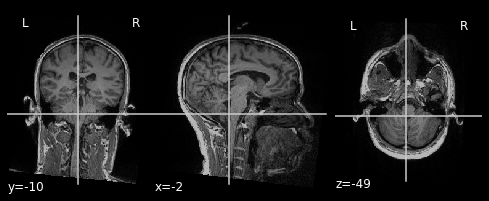

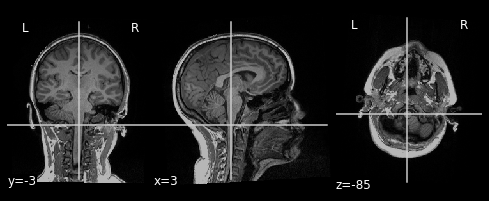

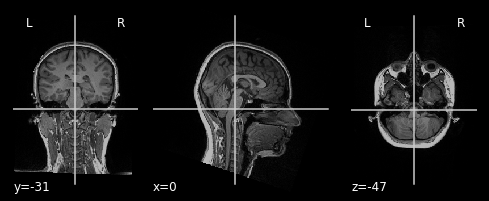

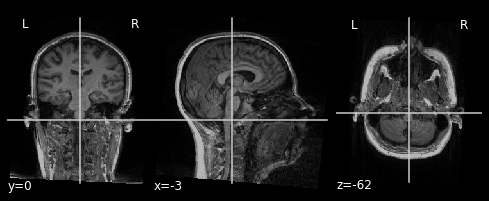

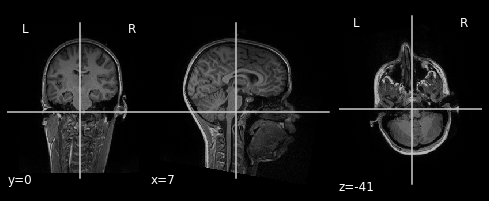

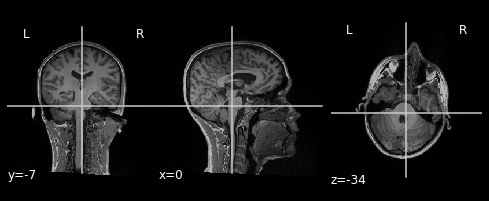

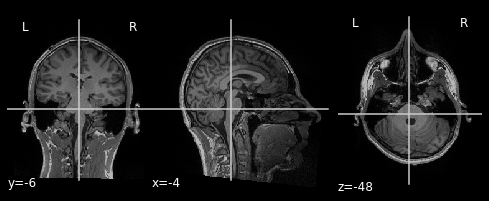

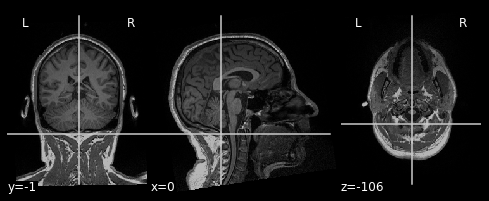

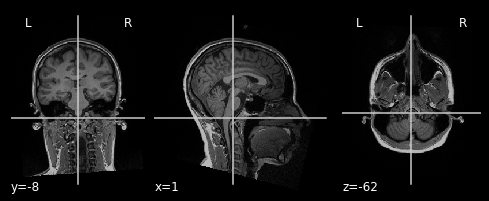

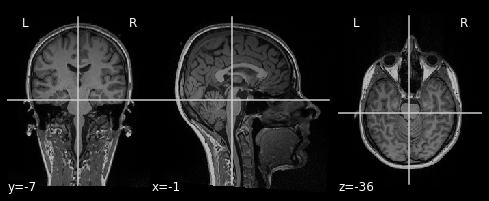

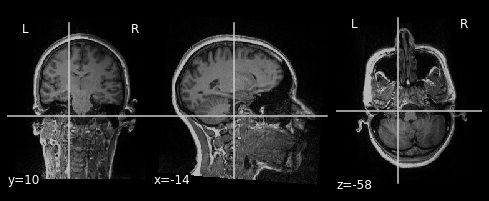

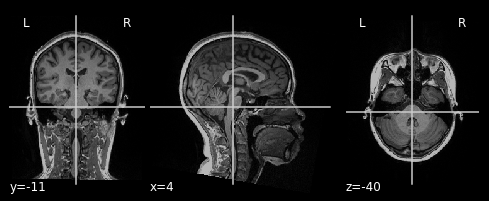

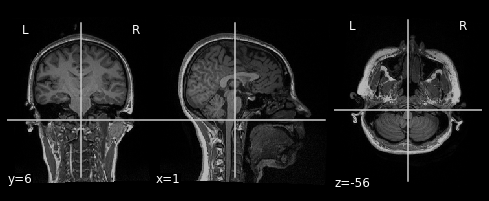

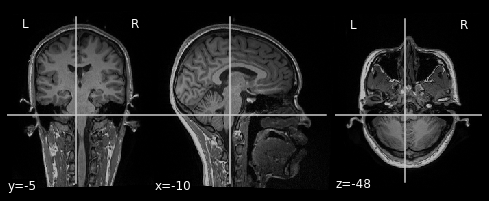

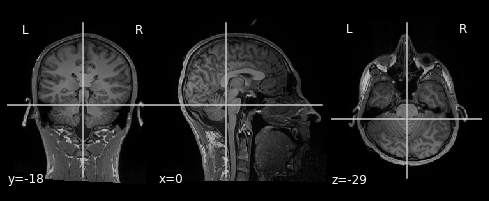

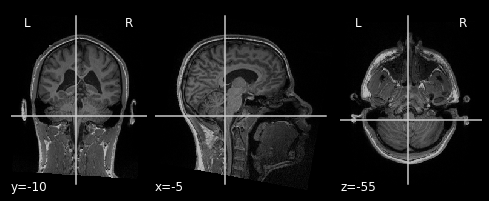

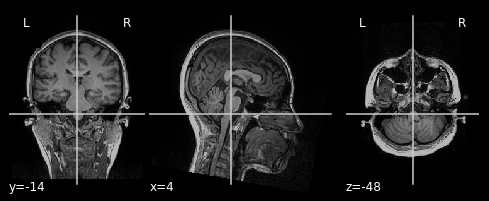

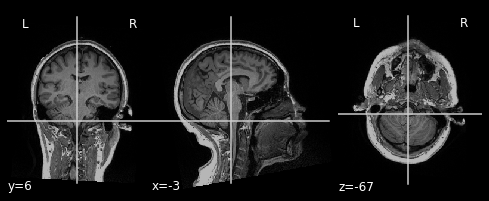

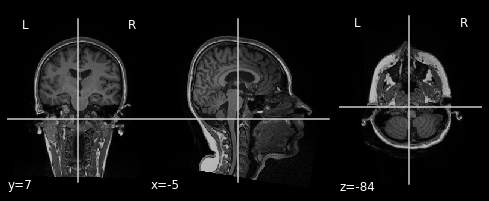

In [2]:
from nilearn import image
from skimage import measure
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from tqdm import tqdm

# list of subjects with cod-liver oil in T1
db_subjects = [['03','04','06','07','08','09','10','11','12','13','15','16','17','18','19','20','22','23','24']] 

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)

        # T1 without cod liver oil (if there was a cod liver oil in the t1)
        T1 = glob.glob(path + '\sub-*T1*withoutcdl.nii')
        # otherwise load the raw T1
        if T1:
            T1 = image.load_img(T1)
        else:
            T1 = image.load_img(glob.glob(path + '\sub-*T1.nii'))

        T1 = new_img_like(T1, T1.get_fdata()[:,:,:,0])

        # electrode mask, segmented with JTK-snap
        el_mask = image.load_img(glob.glob(path + '\\t1_elect_mask.nii'))
        el_mask = new_img_like(el_mask, el_mask.get_fdata()[:,:,:,0])
        el_mask_reversed = np.where(el_mask.get_fdata() == 0, 1, 0)
        
        # This is very inefficient but I don't care now
        import time
        import random
        noise = np.random.randint(10,70,el_mask.get_fdata().size)
        noise = noise.reshape(el_mask_reversed.shape)

        T1_cleaned = T1.get_fdata()*el_mask_reversed #Applying mask
        T1_cleaned = np.where(T1_cleaned == 0, noise, T1_cleaned)
    
        plot_anat(new_img_like(T1, T1_cleaned))
        new_img_like(T1, T1_cleaned).to_filename(path + '\\T1_cleaned.nii')

In [8]:
# Final touch up.
# this loops opens t1_cleaned (raw t1s without the electrodes) and sets to 0 all the values
# that are outide of the head.

import skimage
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output

from nilearn import image
from skimage import measure
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from tqdm import tqdm

# list of subjects with cod-liver oil in T1
db_subjects = [['03','04','06','07','08','09','10','11','12','13','15','16','17','18','19','20','22','23','24']] 
db_subjects = [['14']]

for db_id, db in enumerate(db_names): # Iterate all three datasets
     db_path = os.path.join(data_folder, db) # Dataset folder

     for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
          path = db_path + '\sub-' + subject # Subject folder
          print(path)

          # T1 without cod liver oil (if there was a cod liver oil in the t1)
          T1 = image.load_img(glob.glob(path + '\T1_cleaned.nii'))
          T1_cleaned =  T1.get_fdata()[:,:,:,0]  

          T1_cleaned_bin = np.where(T1_cleaned > 200, 1, 0)
          masked_brain = np.zeros(T1_cleaned_bin.shape)

          for slice in range(0, 255):
               x = T1_cleaned_bin[:,:, slice]
               #plt.imshow(x, cmap=plt.cm.gray)
               #plt.show()

               contours = measure.find_contours(x, 0.1)

               # Display the image and plot all contours found
               maxind = 0
               max = 0
               for i, contour in enumerate(contours):
                    if contour.size > max:
                         max = contour.size
                         maxind = i

               if len(contours) != 0:
                    mask = np.where(measure.grid_points_in_poly([208,256], contours[maxind][:,:]), 1, 0)
                    mask = skimage.morphology.binary_dilation(mask)
                    mask = skimage.morphology.binary_dilation(mask)
               else:
                    mask = np.zeros(x.shape)
               
               x = np.where(mask == 1,  T1_cleaned[:,:, slice], 0)
               masked_brain[:,:,slice] = x
               #plt.imshow(x)
               #plt.imshow(mask)
               #if len(contours) != 0:
                    #plt.plot(contours[maxind][:, 1], contours[maxind][:, 0], linewidth=2)

               #clear_output(wait=True)
          new_img_like(T1, masked_brain).to_filename(path + '\\T1_cleaned.nii')


0it [00:00, ?it/s]

D:\roast-chapter3\wp2a\sub-14


1it [01:12, 72.92s/it]


In [ ]:
# Saving txt files with electrode coordinates.
db_subjects = [['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']] 

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)
        fname = 'customLocations.txt'
        anod = anod_coords[subject]
        cath = cath_coords[subject]
        with open(path + '\\' + fname, 'w') as f:
            f.write('custom1 ' + str(anod[0]) + ' ' + str(anod[1]) + ' ' + str(anod[2]))
            f.writelines('\n')
            f.write('custom2 ' + str(cath[0]) + ' ' + str(cath[1]) + ' ' + str(cath[2]))

22it [00:00, 1297.47it/s]

D:\roast-chapter3\wp2a\sub-01
D:\roast-chapter3\wp2a\sub-02
D:\roast-chapter3\wp2a\sub-03
D:\roast-chapter3\wp2a\sub-04
D:\roast-chapter3\wp2a\sub-06
D:\roast-chapter3\wp2a\sub-07
D:\roast-chapter3\wp2a\sub-08
D:\roast-chapter3\wp2a\sub-09
D:\roast-chapter3\wp2a\sub-10
D:\roast-chapter3\wp2a\sub-11
D:\roast-chapter3\wp2a\sub-12
D:\roast-chapter3\wp2a\sub-13
D:\roast-chapter3\wp2a\sub-14
D:\roast-chapter3\wp2a\sub-15
D:\roast-chapter3\wp2a\sub-16
D:\roast-chapter3\wp2a\sub-17
D:\roast-chapter3\wp2a\sub-18
D:\roast-chapter3\wp2a\sub-19
D:\roast-chapter3\wp2a\sub-20
D:\roast-chapter3\wp2a\sub-22
D:\roast-chapter3\wp2a\sub-23
D:\roast-chapter3\wp2a\sub-24


In [2]:
# Saving txt files with electrode coordinates.
db_subjects = [['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']] 


# MNI coordinates from affine matrix 
import numpy as np
def matrix_to_mni(matrix_coord, T):
    second_arg = np.array([matrix_coord[0],matrix_coord[1],matrix_coord[2], 1])
    second_arg = np.reshape(second_arg,[-1,1])
    mni_coord = np.dot(T,second_arg)
    return np.reshape(mni_coord[0:3],[1,-1])


from nilearn import image
import glob

anod_mni = anod_coords.copy()
cath_mni = cath_coords.copy()

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in enumerate(db_subjects[db_id]): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)
        T1 = image.load_img(glob.glob(path + '\T1_cleaned.nii'))
        anod = anod_coords[subject]
        cath = cath_coords[subject]
        anod_mni[subject] = matrix_to_mni(anod, T1.affine)
        cath_mni[subject] = matrix_to_mni(cath, T1.affine)


np.save('wp2a_anod_mni_coords.npy', anod_mni) 
np.save('wp2a_cath_mni_coords.npy', cath_mni) 


D:\roast-chapter3\wp2a\sub-01
D:\roast-chapter3\wp2a\sub-02
D:\roast-chapter3\wp2a\sub-03
D:\roast-chapter3\wp2a\sub-04
D:\roast-chapter3\wp2a\sub-06
D:\roast-chapter3\wp2a\sub-07
D:\roast-chapter3\wp2a\sub-08
D:\roast-chapter3\wp2a\sub-09
D:\roast-chapter3\wp2a\sub-10
D:\roast-chapter3\wp2a\sub-11
D:\roast-chapter3\wp2a\sub-12
D:\roast-chapter3\wp2a\sub-13
D:\roast-chapter3\wp2a\sub-14
D:\roast-chapter3\wp2a\sub-15
D:\roast-chapter3\wp2a\sub-16
D:\roast-chapter3\wp2a\sub-17
D:\roast-chapter3\wp2a\sub-18
D:\roast-chapter3\wp2a\sub-19
D:\roast-chapter3\wp2a\sub-20
D:\roast-chapter3\wp2a\sub-22
D:\roast-chapter3\wp2a\sub-23
D:\roast-chapter3\wp2a\sub-24
